In [1]:
import sys
sys.path.append('../')
from src import mlp_quantile
from src import metrics as _metrics
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
import seaborn as sns

sns.set(rc={'figure.figsize':(20,8)})
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
pd.set_option('display.max_rows', 120)

* https://towardsdatascience.com/quantile-regression-from-linear-models-to-trees-to-deep-learning-af3738b527c3
* https://towardsdatascience.com/lightgbm-for-quantile-regression-4288d0bb23fd
* https://towardsdatascience.com/deep-quantile-regression-in-tensorflow-1dbc792fe597
* https://github.com/sachinruk/KerasQuantileModel/blob/master/Keras%20Quantile%20Model.ipynb

## Reading / Displaying the Data 

In [2]:
df_dataset_v2 = pd.read_csv('../data/forecast_dataset_exp11.csv')

In [3]:
df_dataset_v2.describe()

,month,Y,hc_cluster_1,hc_cluster_2,hc_cluster_3,hc_cluster_4,hc_cluster_5,hc_cluster_6,hc_cluster_7,hc_cluster_8,...,cat_code_1,cat_code_2,cat_code_3,cat_code_4,cat_code_5,cat_code_6,cat_code_7,cat_code_8,cat_code_9,cat_code_10
count,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,...,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000
mean,6.318052,108.926934,0.349570,0.491404,0.012178,0.018625,0.017192,0.018625,0.006447,0.070917,...,0.010029,0.005014,0.007880,0.063037,0.018625,0.018625,0.006447,0.007880,0.009312,0.012178
std,3.471418,235.188518,0.477005,0.500105,0.109718,0.135244,0.130033,0.135244,0.080063,0.256778,...,0.099675,0.070659,0.088449,0.243117,0.135244,0.135244,0.080063,0.088449,0.096084,0.109718
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.000000,90.250000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,12.000000,2063.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
df_dataset_v2.head()

,code,year_month,month,Y,hc_cluster_1,hc_cluster_2,hc_cluster_3,hc_cluster_4,hc_cluster_5,hc_cluster_6,...,cat_code_1,cat_code_2,cat_code_3,cat_code_4,cat_code_5,cat_code_6,cat_code_7,cat_code_8,cat_code_9,cat_code_10
0,0671c2b9132a3f5215a4212ce0691694,2016-11,11,664,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0671c2b9132a3f5215a4212ce0691694,2016-12,12,225,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0671c2b9132a3f5215a4212ce0691694,2017-01,1,211,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0671c2b9132a3f5215a4212ce0691694,2017-02,2,634,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0671c2b9132a3f5215a4212ce0691694,2017-03,3,1343,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
X_cols = [c for c in df_dataset_v2.columns if c not in ['year_month', 'Y'] and 'hc_cluster' not in c]

In [6]:
df_dataset_v2['code'] = df_dataset_v2['code'].astype('category').cat.codes

In [7]:
X_cols

['code',
 'month',
 'kmeans_cluster_0',
 'kmeans_cluster_1',
 'kmeans_cluster_2',
 'kmeans_cluster_3',
 'kmeans_cluster_4',
 'kmeans_cluster_5',
 'kmeans_cluster_6',
 'kmeans_cluster_7',
 'kmeans_cluster_8',
 'cat_code_0',
 'cat_code_1',
 'cat_code_2',
 'cat_code_3',
 'cat_code_4',
 'cat_code_5',
 'cat_code_6',
 'cat_code_7',
 'cat_code_8',
 'cat_code_9',
 'cat_code_10']

In [8]:
df_dataset_v2[X_cols].head()

,code,month,kmeans_cluster_0,kmeans_cluster_1,kmeans_cluster_2,kmeans_cluster_3,kmeans_cluster_4,kmeans_cluster_5,kmeans_cluster_6,kmeans_cluster_7,...,cat_code_1,cat_code_2,cat_code_3,cat_code_4,cat_code_5,cat_code_6,cat_code_7,cat_code_8,cat_code_9,cat_code_10
0,0,11,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,12,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,3,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Splitting the Sets
* We will use the temporal series cross validation
* 3 months minimum intervals
* 3 training, 6 validation, 3 test
* 4 training, 5 validation, 3 test
* 5 training, 4 validation, 3 test
* 6 training, 3 validation, 3 test

In [9]:
df_train_val_test = pd.read_csv('../data/train_val_test.csv')

In [10]:
df_train_val_test

,set,train,val,reserved
0,0,"['2016-06', '2016-07', '2016-08']","['2016-09', '2016-10', '2016-11', '2016-12', '...",False
1,1,"['2016-06', '2016-07', '2016-08', '2016-09']","['2016-10', '2016-11', '2016-12', '2017-01', '...",False
2,2,"['2016-06', '2016-07', '2016-08', '2016-09', '...","['2016-11', '2016-12', '2017-01', '2017-02']",False
3,3,"['2016-06', '2016-07', '2016-08', '2016-09', '...","['2016-12', '2017-01', '2017-02']",False
4,4,"['2016-06', '2016-07', '2016-08', '2016-09', '...","['2017-01', '2017-02']",False
5,5,"['2016-06', '2016-07', '2016-08', '2016-09', '...",['2017-02'],False
6,6,"['2016-06', '2016-07', '2016-08', '2016-09', '...","['2017-03', '2017-04', '2017-05']",True


## Regressors Init

In [11]:
regressors = {}
RANDOM_STATE = 42
q =0.5

In [12]:
import lightgbm as lgb
gbm = lgb.LGBMRegressor(random_state=RANDOM_STATE)
regressors['gbm'] = gbm

In [13]:
import lightgbm as lgb
gbm_q = lgb.LGBMRegressor(alpha=q, objective = 'quantile',
    metric = 'quantile',random_state=RANDOM_STATE)
regressors['gbm_q'] = gbm_q

In [14]:
from sklearn.ensemble import GradientBoostingRegressor
gb_q = GradientBoostingRegressor(loss='quantile', alpha=q)
regressors['gb_q'] = gb_q

In [15]:

mlp_q = mlp_quantile.QuantileModel(input_dims=len(X_cols), q=q)
regressors['mlp_q'] = mlp_q

In [16]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Train Eval



In [17]:
def parse_str_list(str_list):
    result = str_list.replace("'","").replace('[','').replace(']','').replace(' ', '').split(',')
    return result

In [18]:
sets = list(df_train_val_test[~df_train_val_test.reserved].set.values)
sets

[0, 1, 2, 3, 4, 5]

In [19]:
results = []
for r_name, r in regressors.items():
    for s in sets:
        df_set = df_train_val_test[~df_train_val_test.reserved & (df_train_val_test.set == s)]

        x_scaler = MinMaxScaler()
        
        train_years = parse_str_list(df_set.train.values[0])
        val_years = parse_str_list(df_set.val.values[0])
        print(f'Training {r_name} on set {s}')
        

        df_train = df_dataset_v2[df_dataset_v2.year_month.isin(train_years)]
        df_val = df_dataset_v2[df_dataset_v2.year_month.isin(val_years)]
    
        y_train = df_train['Y'].values    
        y_val = df_val['Y'].values
        
        if 'mlp' in r_name:
            r_inst = r.fit(X=x_scaler.fit_transform(df_train[X_cols]), y=y_train, 
                       X_val = x_scaler.transform(df_val[X_cols]), y_val = y_val)
        else: 
            r_inst = r.fit(X=x_scaler.fit_transform(df_train[X_cols]), y=y_train)
        
        print(f'Validating {r_name}  on set {s}')
        
        y_pred_val = r_inst.predict(x_scaler.transform(df_val[X_cols]))
        
        y_pred_val = y_pred_val
        m = _metrics.applyRegressionMetrics(y=y_val, y_pred=y_pred_val)
        m['reg_inst'] = r_inst
        m['r_name'] = r_name
        m['set'] = s
        results.append(m)

    print()
df_results = pd.DataFrame(results)    

Training gbm on set 0
Validating gbm  on set 0
Training gbm on set 1
Validating gbm  on set 1
Training gbm on set 2
Validating gbm  on set 2
Training gbm on set 3
Validating gbm  on set 3
Training gbm on set 4
Validating gbm  on set 4
Training gbm on set 5
Validating gbm  on set 5

Training gbm_q on set 0
Validating gbm_q  on set 0
Training gbm_q on set 1
Validating gbm_q  on set 1
Training gbm_q on set 2
Validating gbm_q  on set 2
Training gbm_q on set 3
Validating gbm_q  on set 3
Training gbm_q on set 4
Validating gbm_q  on set 4
Training gbm_q on set 5
Validating gbm_q  on set 5

Training gb_q on set 0
Validating gb_q  on set 0
Training gb_q on set 1
Validating gb_q  on set 1
Training gb_q on set 2
Validating gb_q  on set 2
Training gb_q on set 3
Validating gb_q  on set 3
Training gb_q on set 4
Validating gb_q  on set 4
Training gb_q on set 5
Validating gb_q  on set 5

Training mlp_q on set 0
Validating mlp_q  on set 0
Training mlp_q on set 1
Validating mlp_q  on set 1
Training mlp_

In [20]:
metric_list = []

In [21]:
df_results.groupby('r_name').agg({'RMSE':[pd.Series.mean, pd.Series.std],
                                  'MDAPE':[pd.Series.mean, pd.Series.std],'MAPE':[pd.Series.mean, pd.Series.std],
                                  'MSE':[pd.Series.mean, pd.Series.std],
                                  'MAE':[pd.Series.mean, pd.Series.std],'R2':[pd.Series.mean, pd.Series.std],})

RMSE                MDAPE                MAPE            \
              mean        std      mean       std      mean       std   
r_name                                                                  
gb_q    201.114945  32.045787  0.693303  0.037761  1.987907  1.032548   
gbm     156.711332  26.394419  0.898737  0.083202  4.362639  1.245118   
gbm_q   213.952630  24.668600  0.729433  0.029794  1.758205  0.437551   
mlp_q   241.326299  23.592868  0.895446  0.072854  5.034980  1.930383   

                 MSE                       MAE                   R2            
                mean           std        mean        std      mean       std  
r_name                                                                         
gb_q    41302.998131  11879.609954   82.306308  13.814207  0.252687  0.116531  
gbm     25138.996137   7781.513079   88.103638  12.327617  0.545356  0.085530  
gbm_q   46282.844582   9863.648890   88.774909  10.853968  0.151680  0.054570  
mlp_q   58702.235328  10814.717365  108.368628  17.295226 -0.082715  0.056506

Training gbm on set 6
Validating gbm on set 6 and 2017-03
932 125
RMSE : 147.4027
MAPE': 3.0787
MDAPE': 0.7838
MSE: 21727.5600
MAE: 70.7280
R2: 0.6135


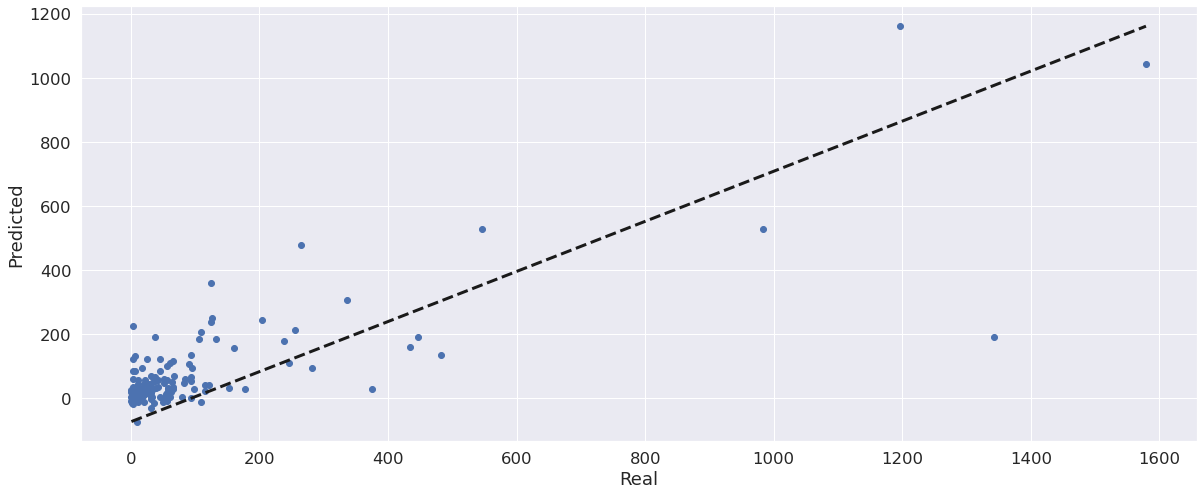

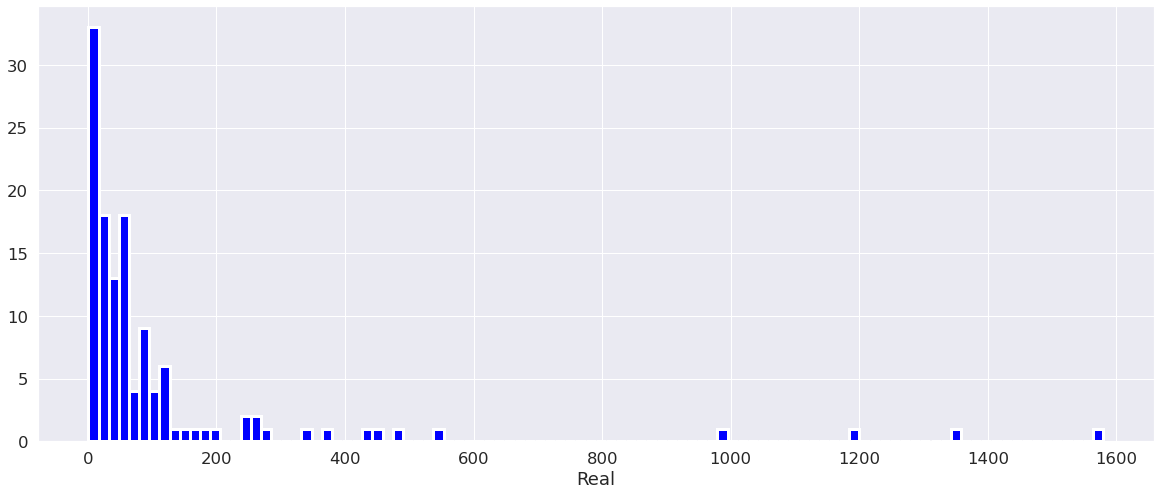

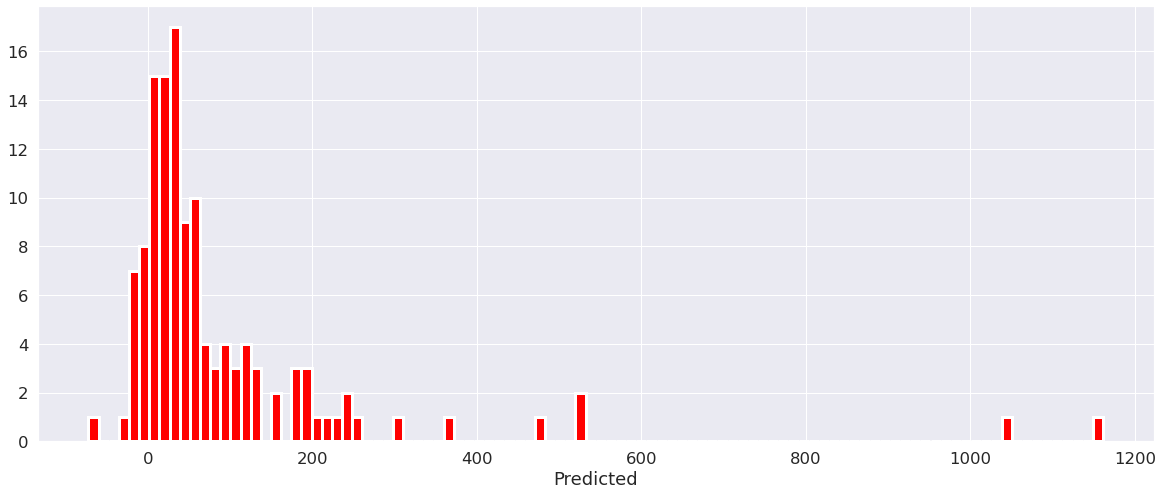


Validating gbm on set 6 and 2017-04
932 122
RMSE : 134.3096
MAPE': 2.8030
MDAPE': 0.7163
MSE: 18039.0738
MAE: 67.0738
R2: 0.6312


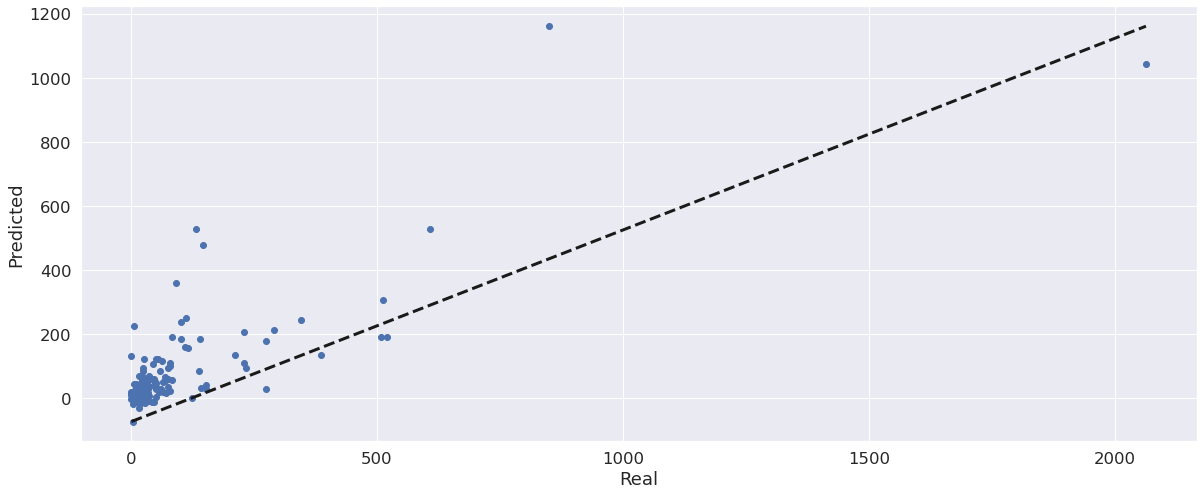

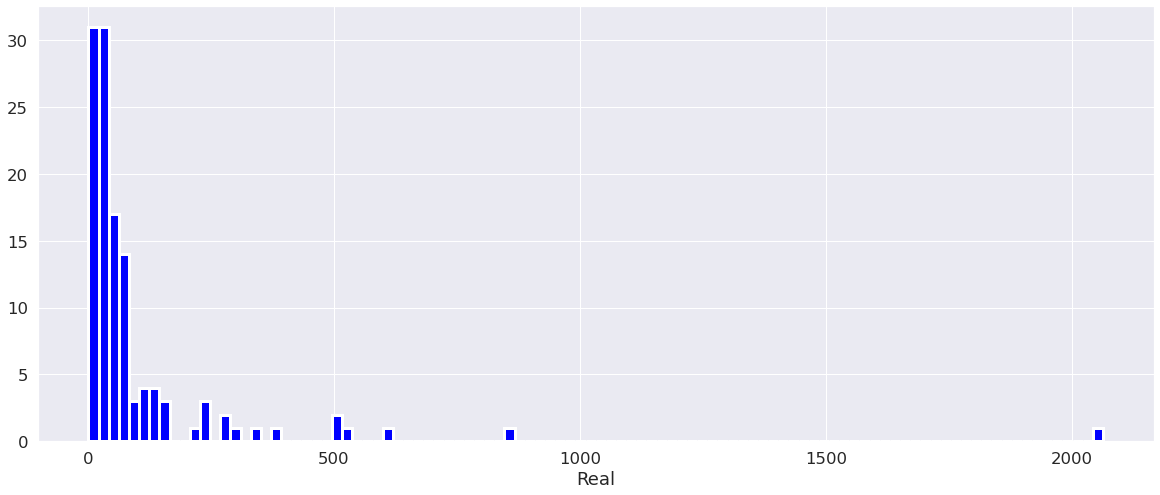

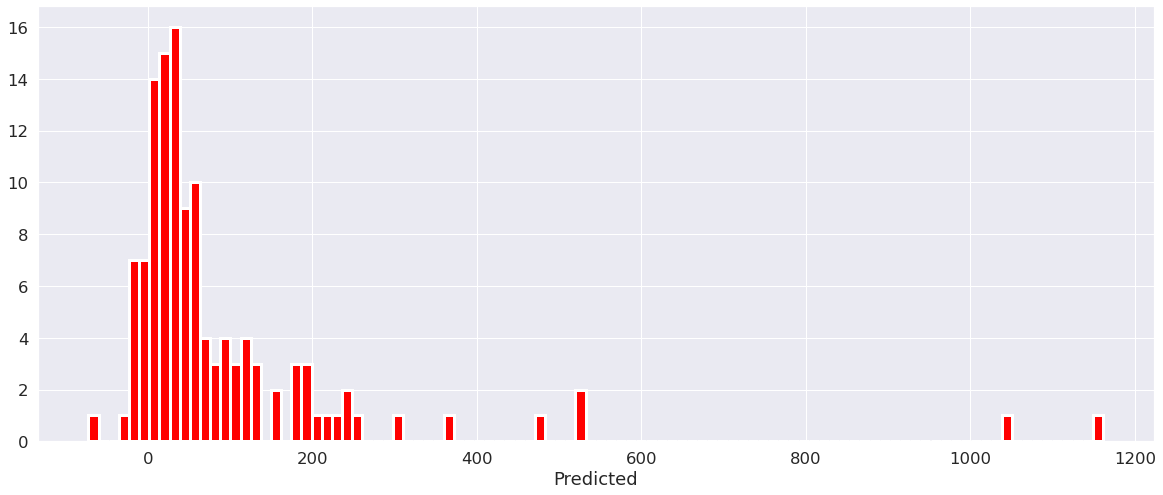


Validating gbm on set 6 and 2017-05
932 121
RMSE : 184.6044
MAPE': 8.3834
MDAPE': 0.7553
MSE: 34078.8017
MAE: 96.1240
R2: 0.5429


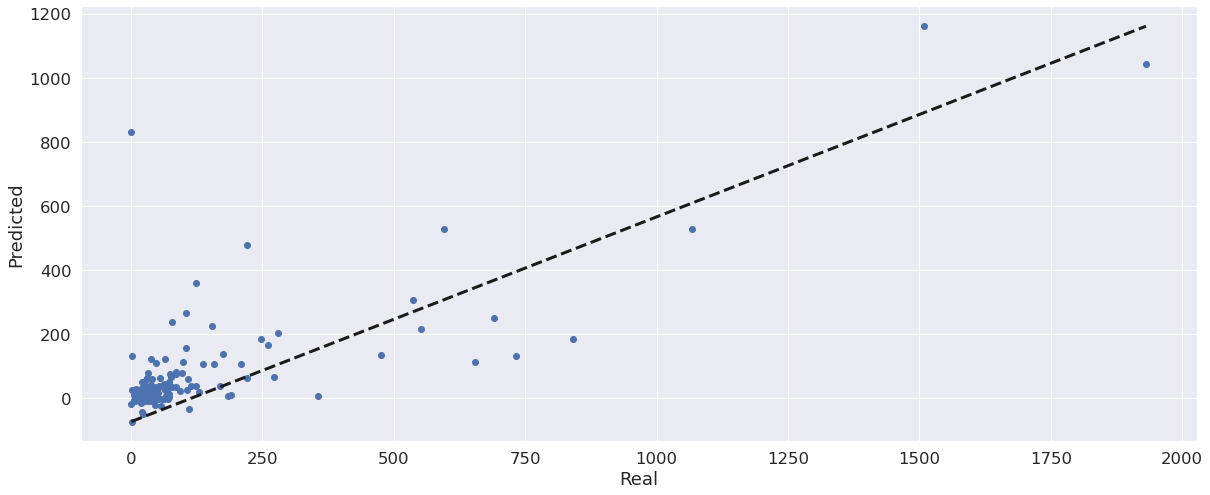

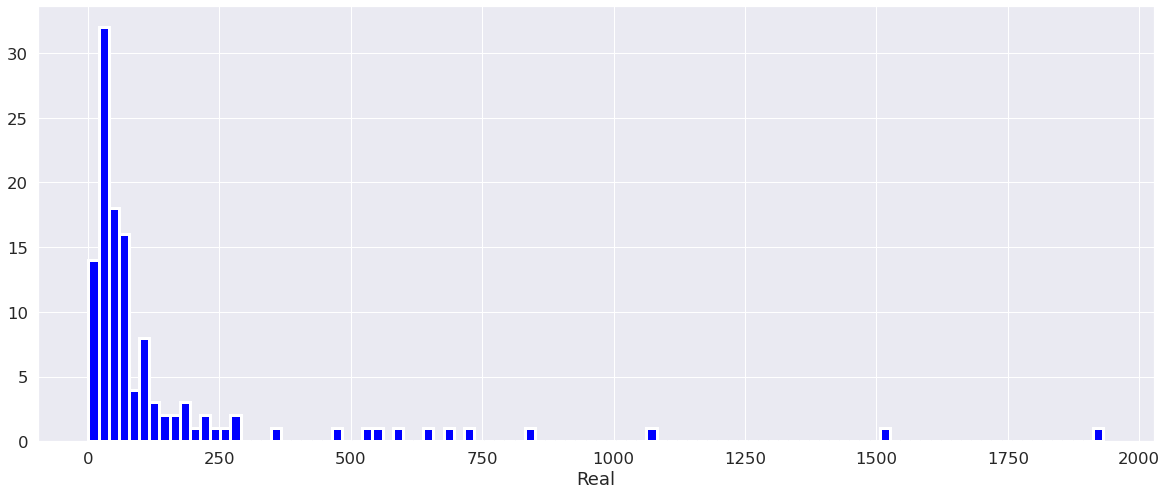

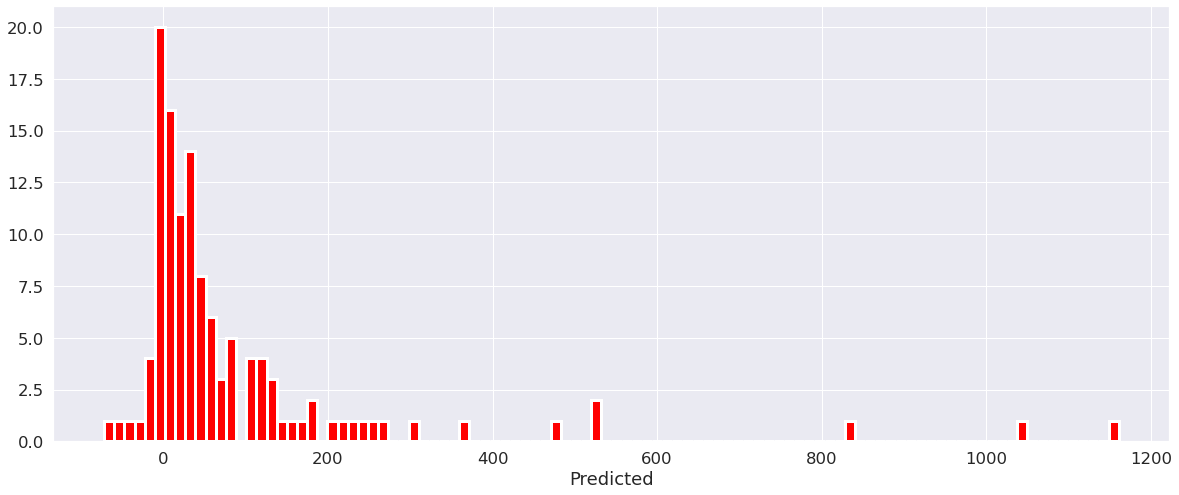


Training gbm_q on set 6
Validating gbm_q on set 6 and 2017-03
932 125
RMSE : 203.2811
MAPE': 1.7074
MDAPE': 0.5556
MSE: 41323.2240
MAE: 76.4560
R2: 0.2648


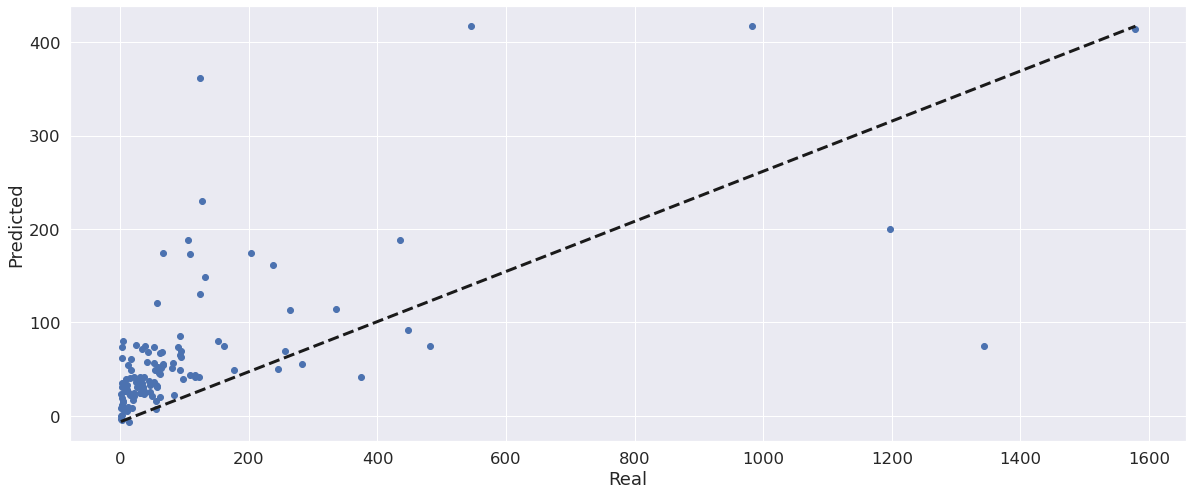

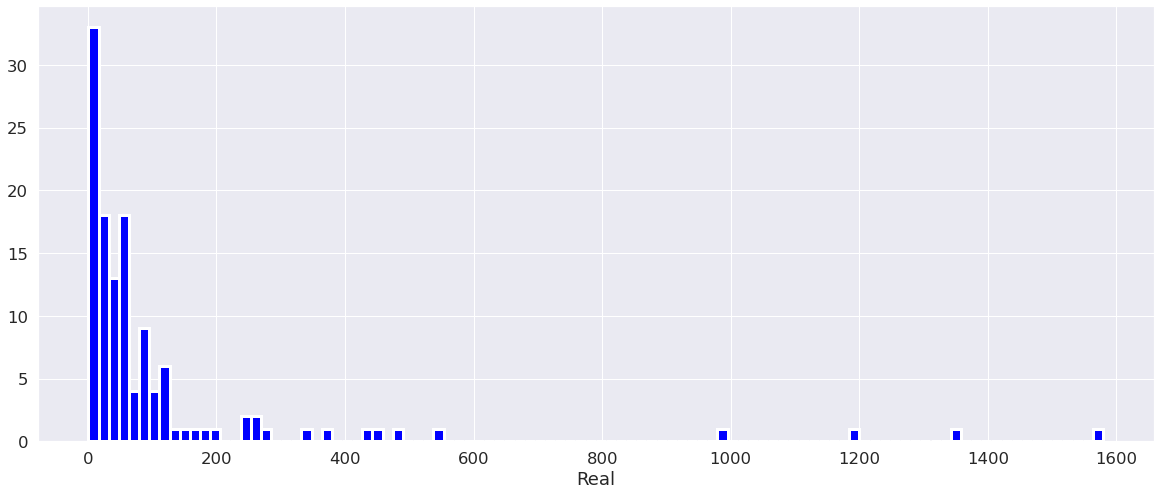

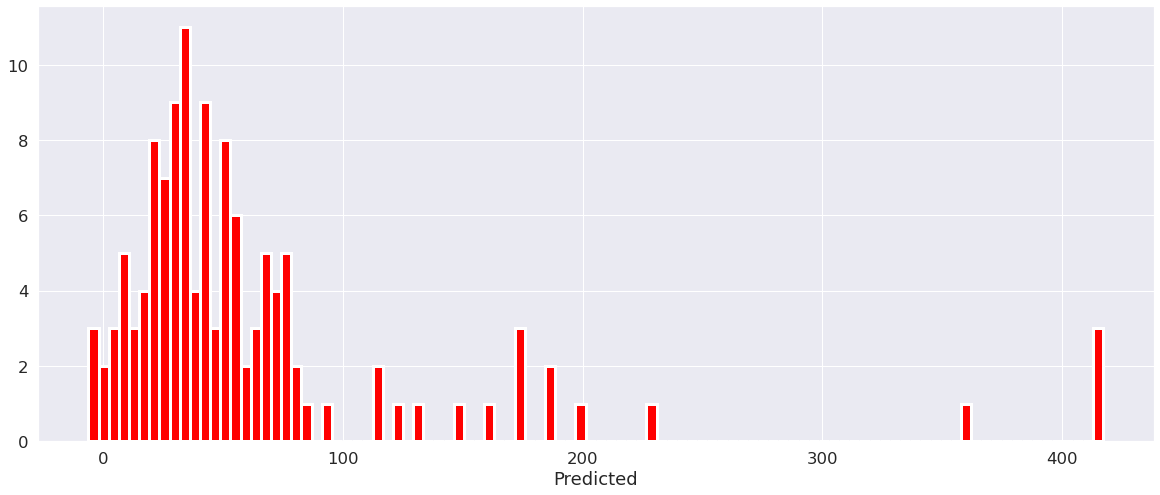


Validating gbm_q on set 6 and 2017-04
932 122
RMSE : 187.7551
MAPE': 1.0775
MDAPE': 0.5062
MSE: 35251.9918
MAE: 66.9918
R2: 0.2792


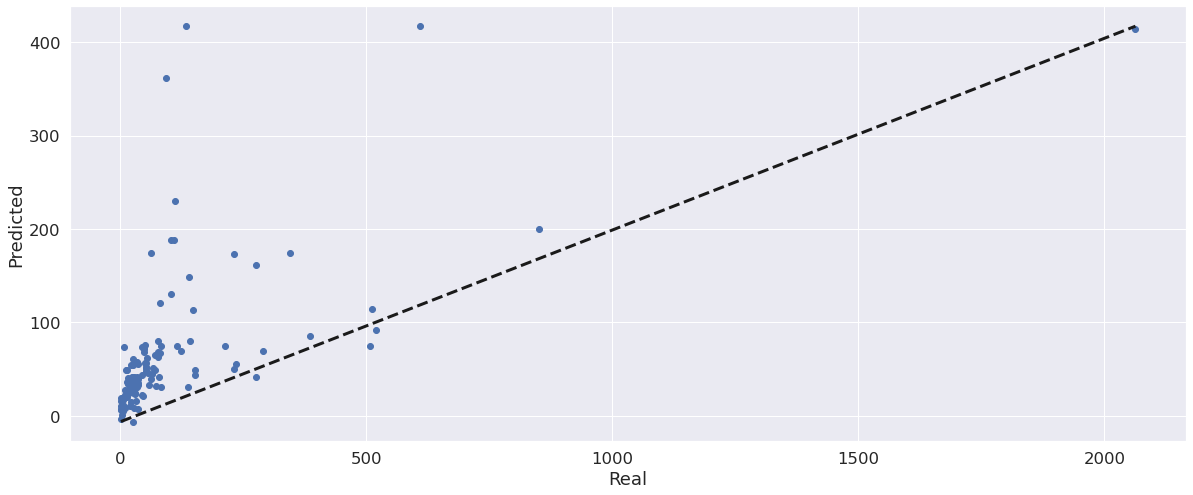

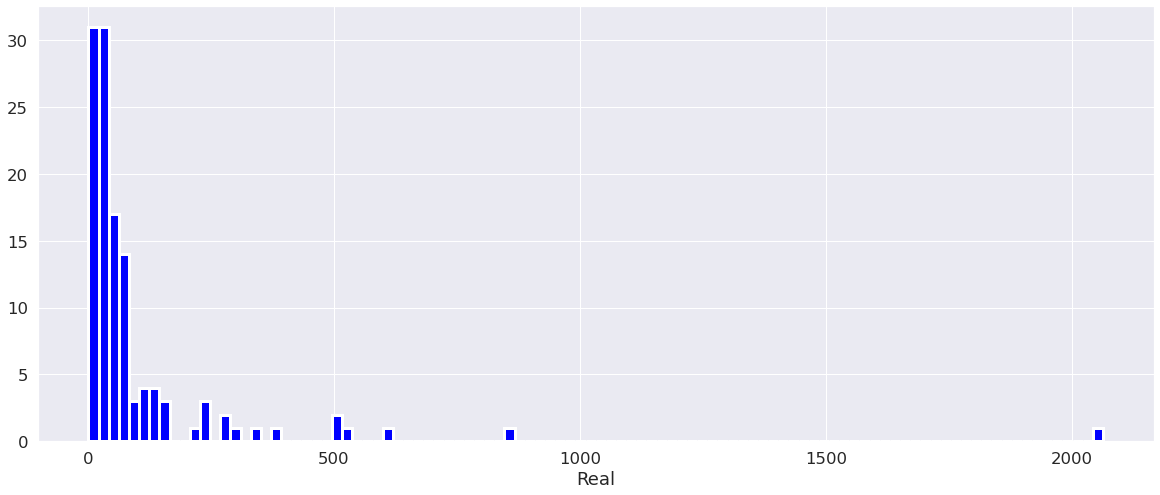

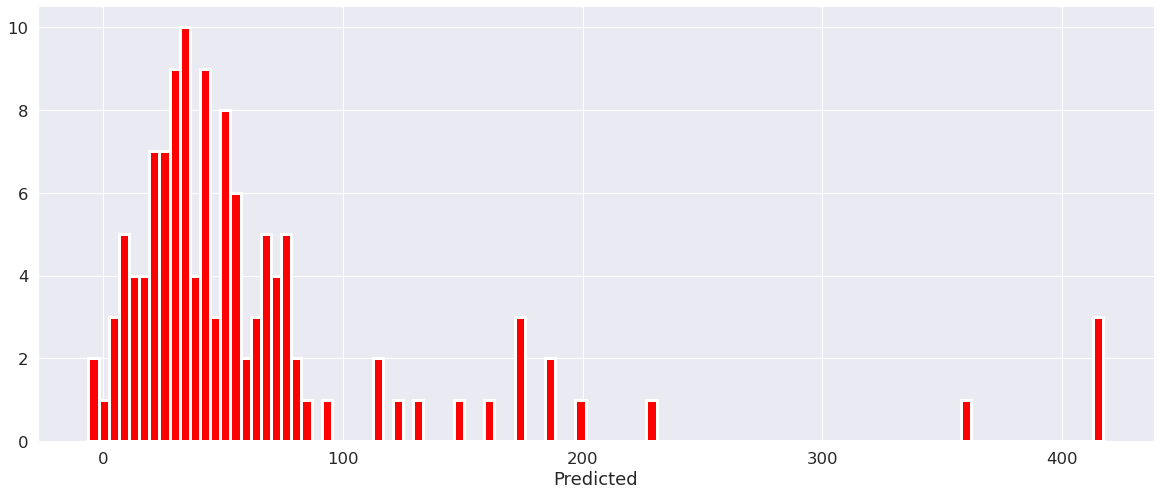


Validating gbm_q on set 6 and 2017-05
932 121
RMSE : 236.8652
MAPE': 0.8796
MDAPE': 0.6667
MSE: 56105.1074
MAE: 100.8430
R2: 0.2475


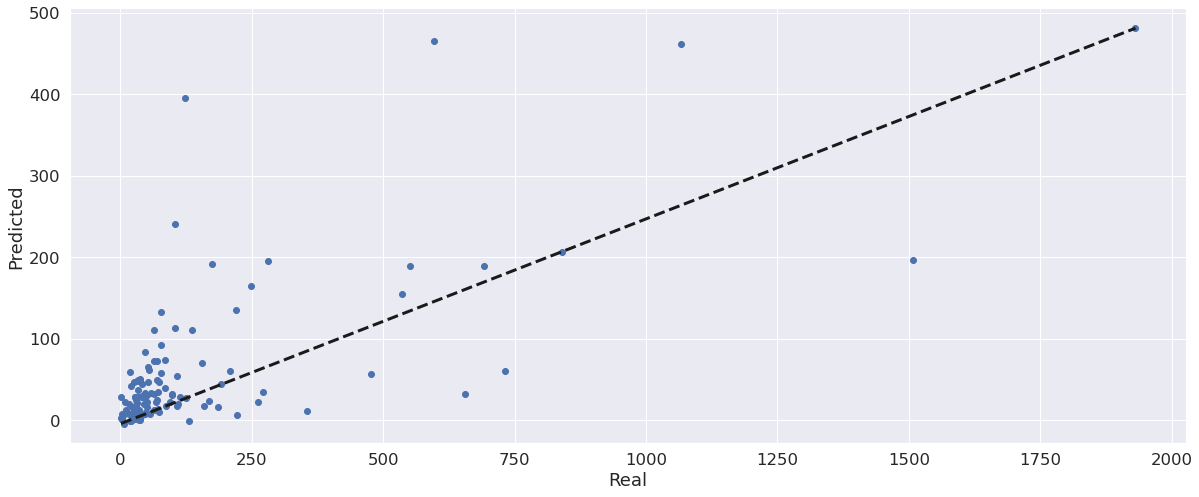

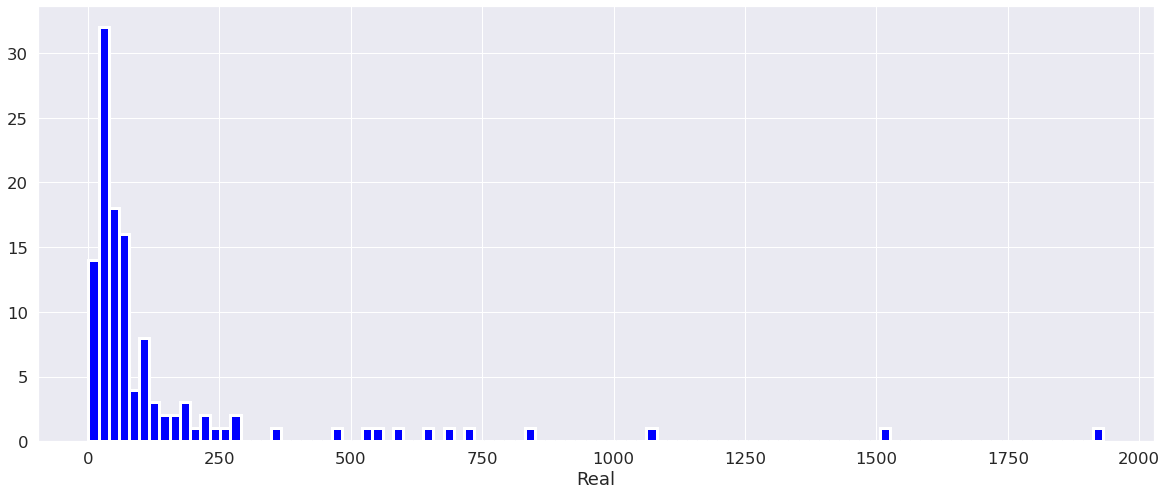

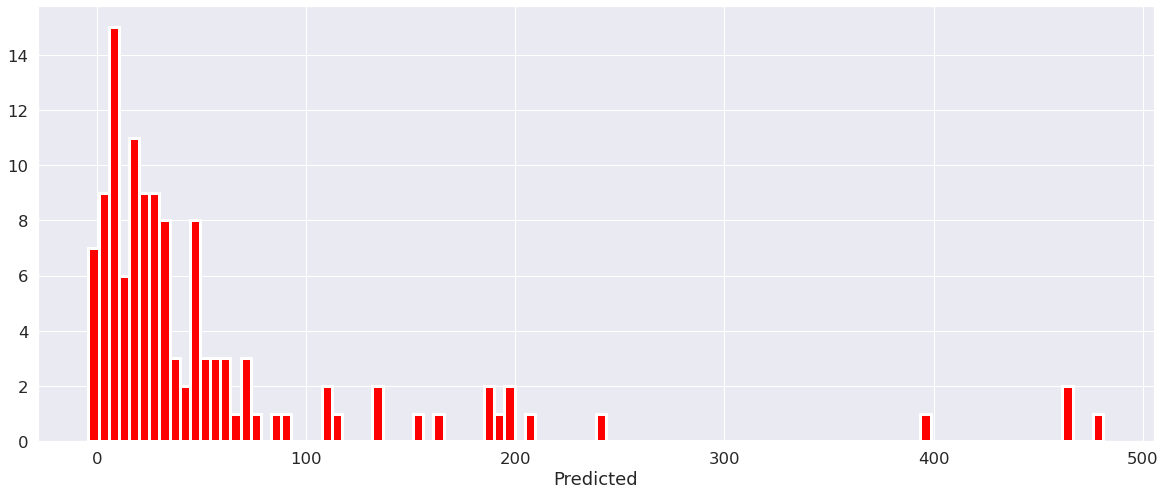


Training gb_q on set 6
Validating gb_q on set 6 and 2017-03
932 125
RMSE : 199.5231
MAPE': 2.0369
MDAPE': 0.5714
MSE: 39809.4560
MAE: 74.9920
R2: 0.2918


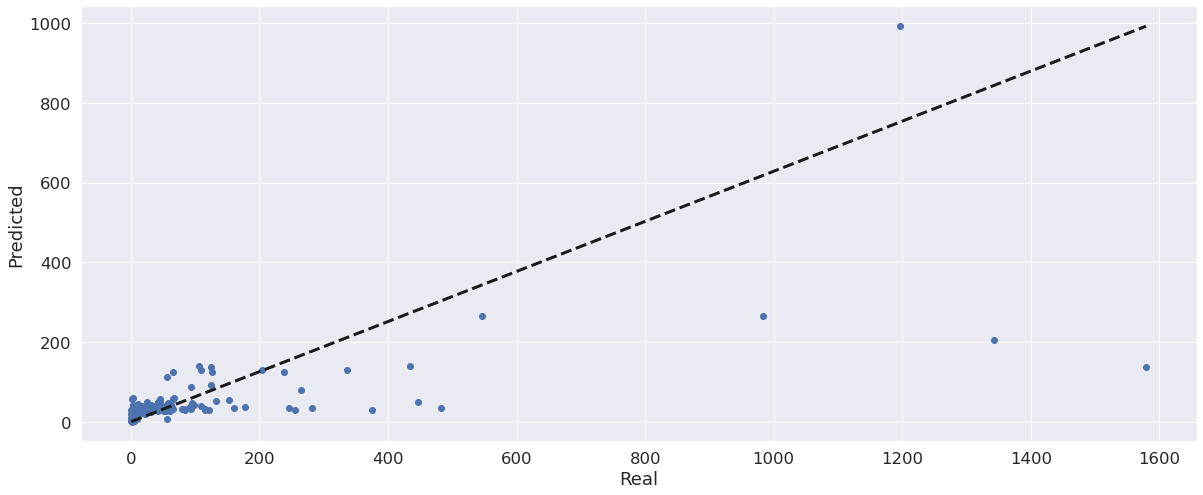

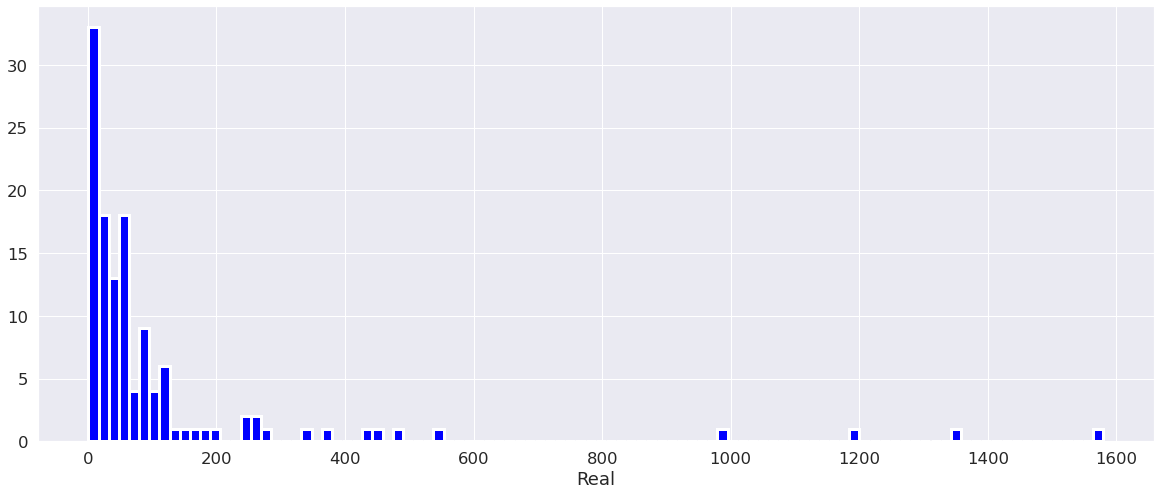

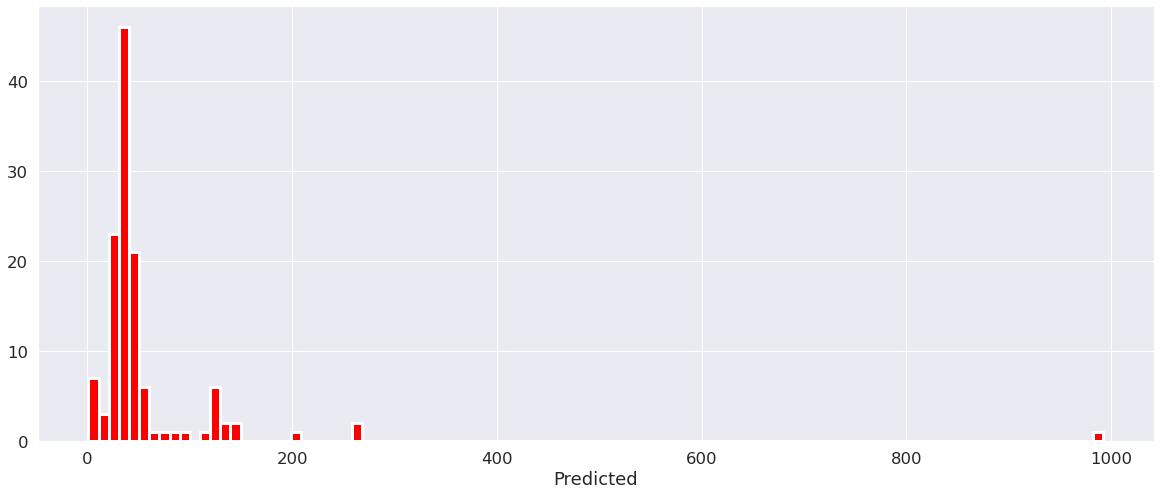


Validating gb_q on set 6 and 2017-04
932 122
RMSE : 199.3274
MAPE': 1.0729
MDAPE': 0.5417
MSE: 39731.4262
MAE: 64.9836
R2: 0.1877


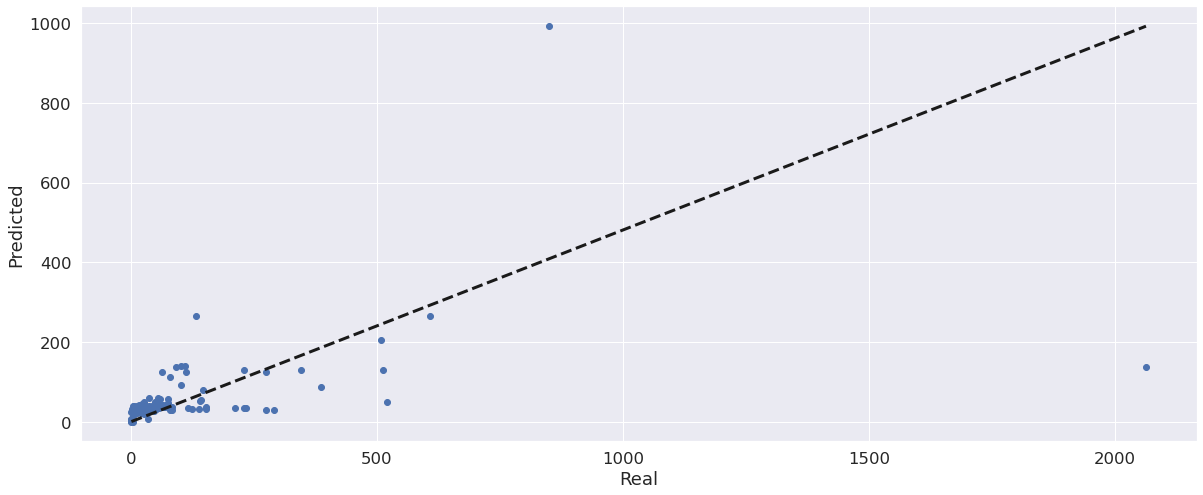

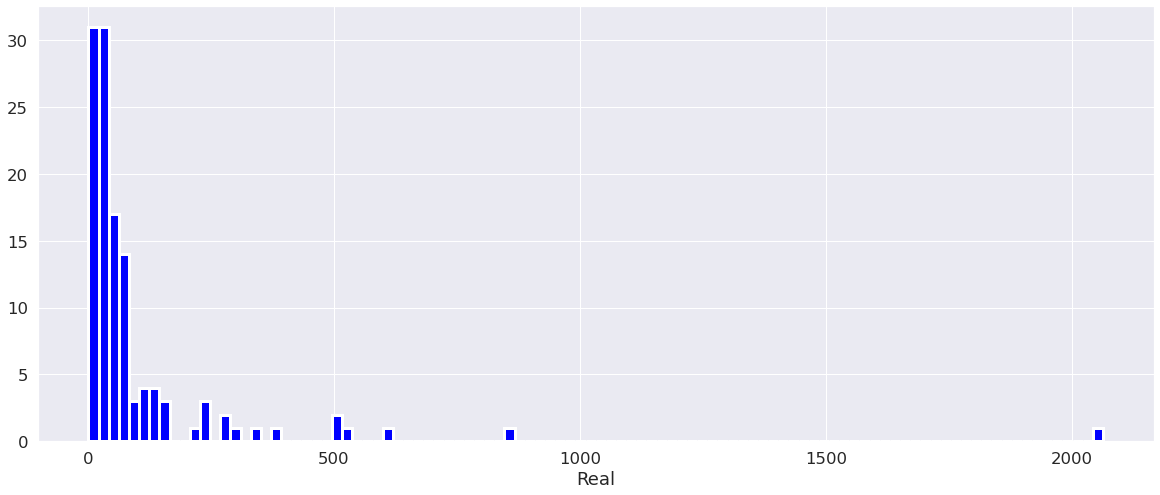

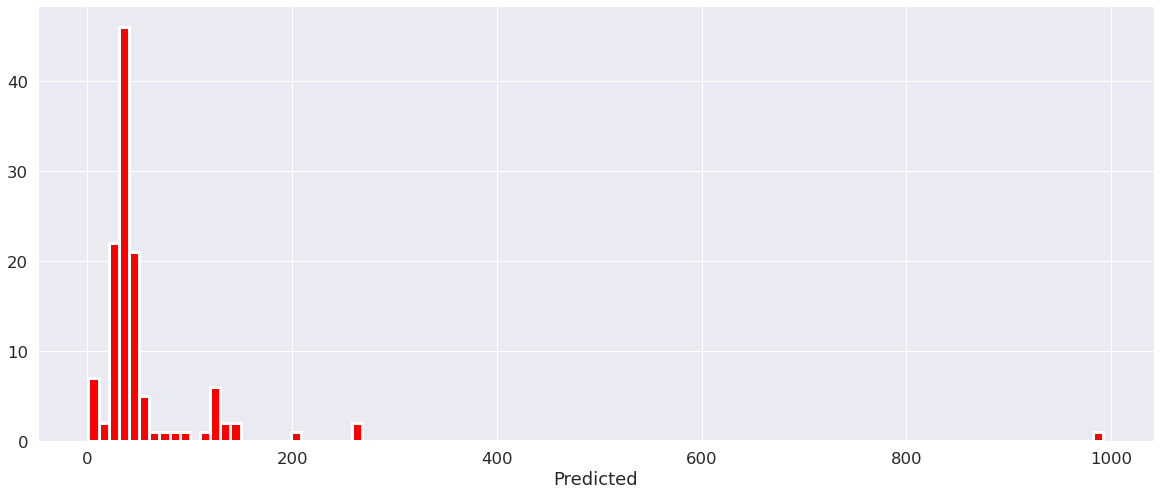


Validating gb_q on set 6 and 2017-05
932 121
RMSE : 236.8339
MAPE': 0.7513
MDAPE': 0.5405
MSE: 56090.3140
MAE: 97.3554
R2: 0.2477


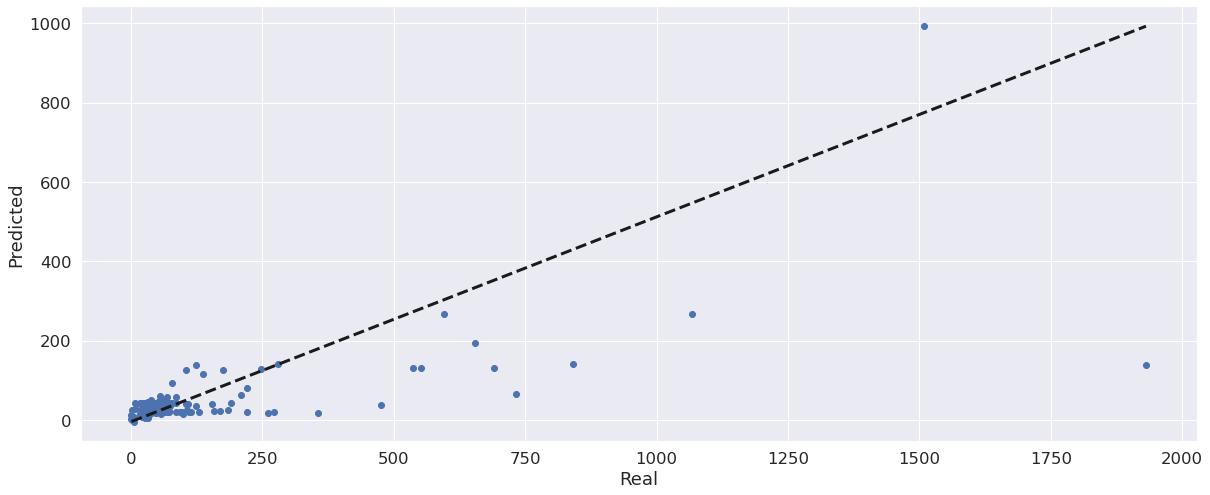

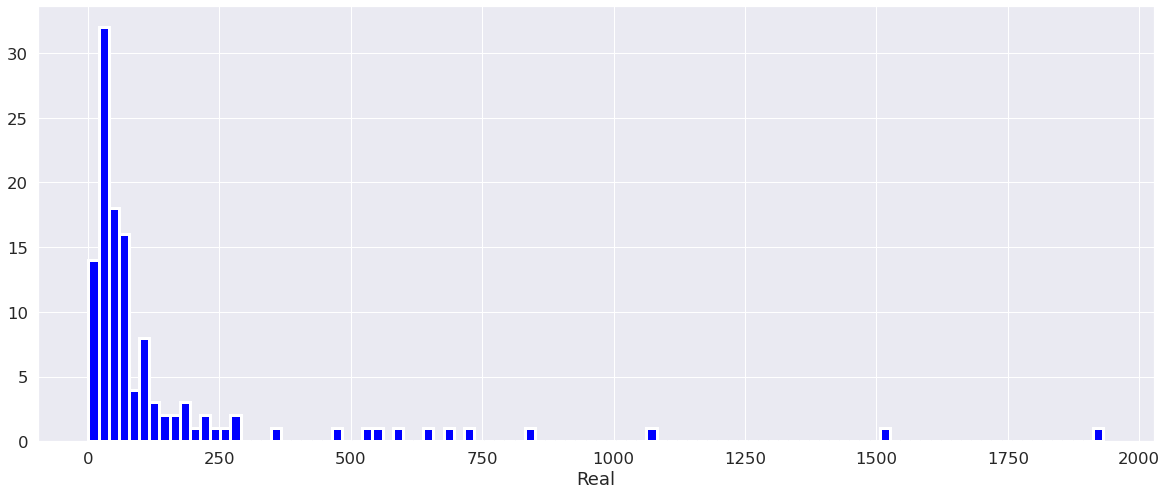

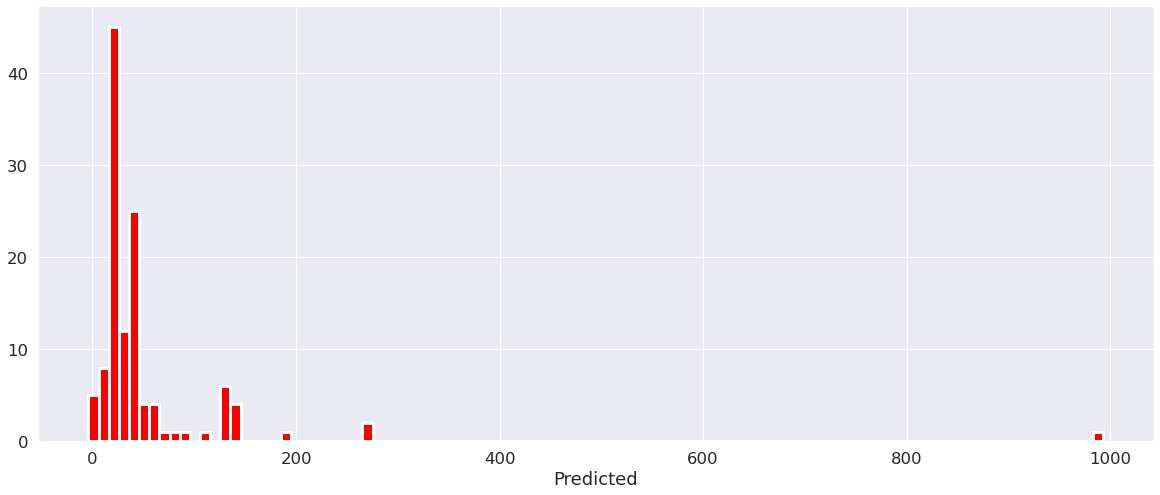


Training mlp_q on set 6
Validating mlp_q on set 6 and 2017-03
932 125
RMSE : 240.0904
MAPE': 6.0579
MDAPE': 0.9203
MSE: 57643.3840
MAE: 105.1280
R2: -0.0255


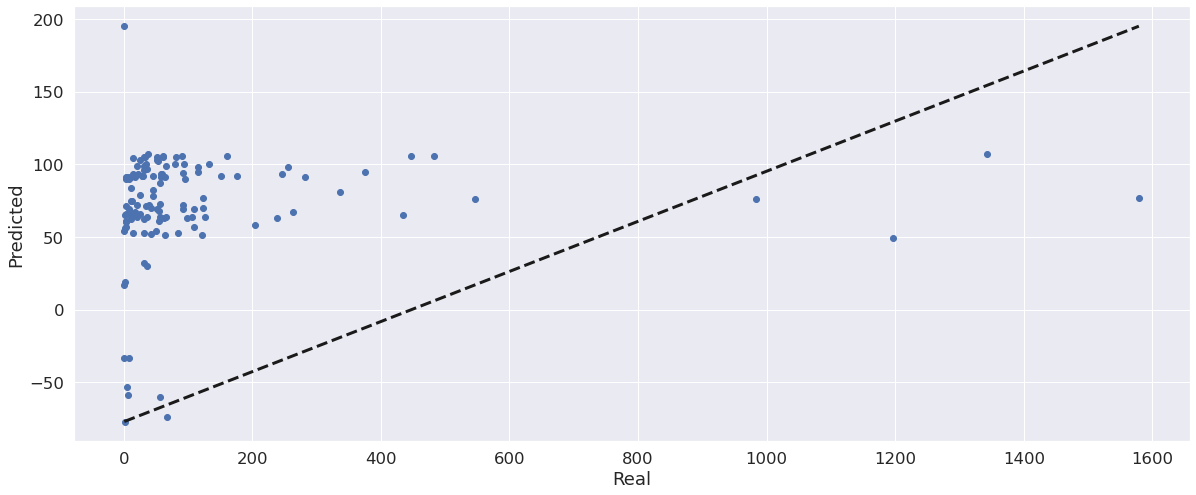

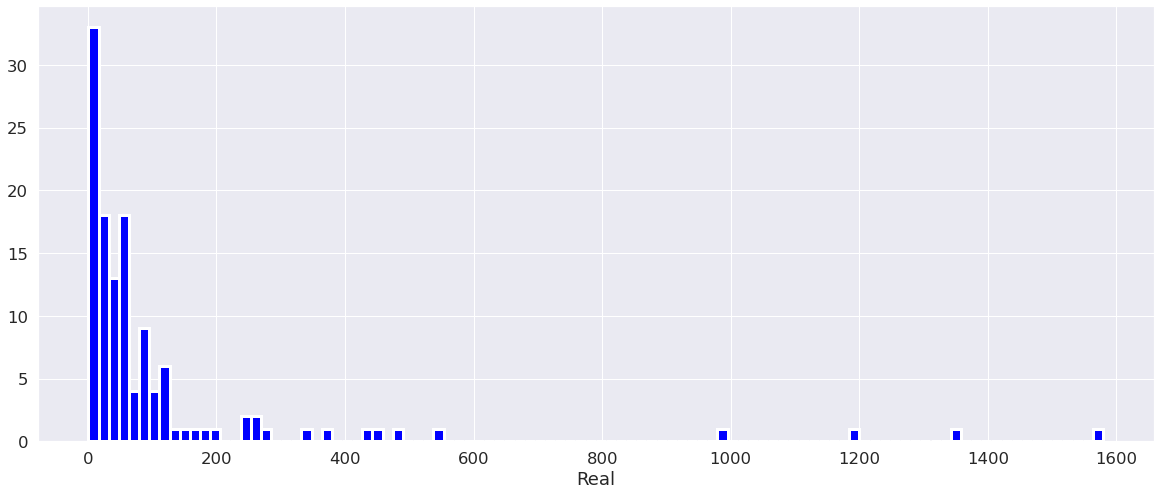

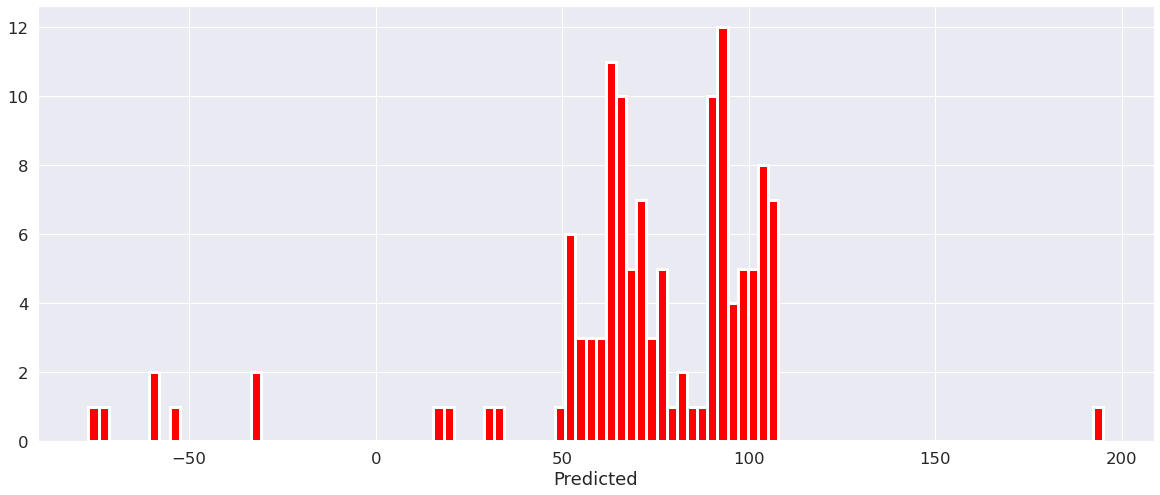


Validating mlp_q on set 6 and 2017-04
932 122
RMSE : 222.6667
MAPE': 3.9037
MDAPE': 0.8967
MSE: 49580.4590
MAE: 90.3279
R2: -0.0137


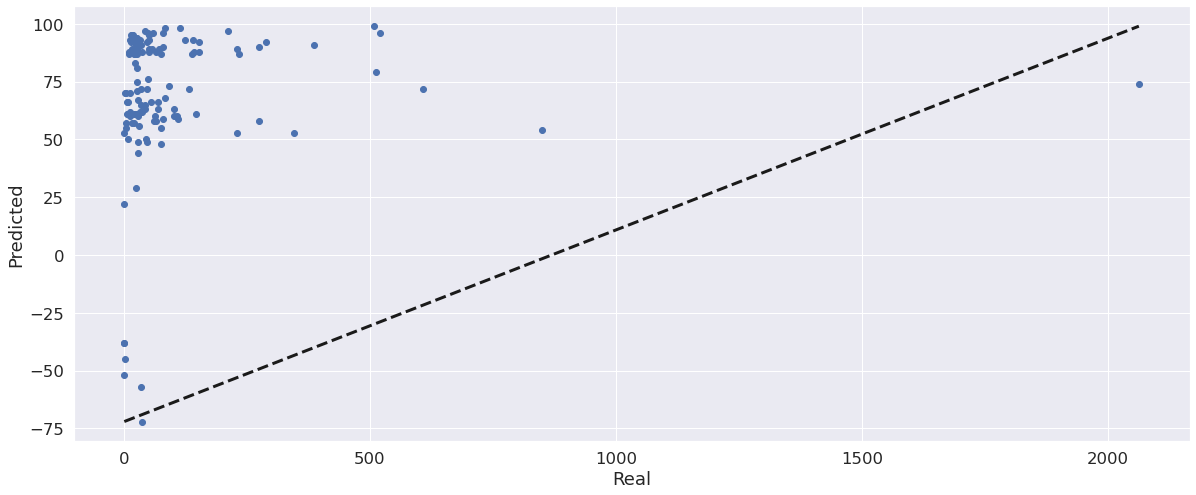

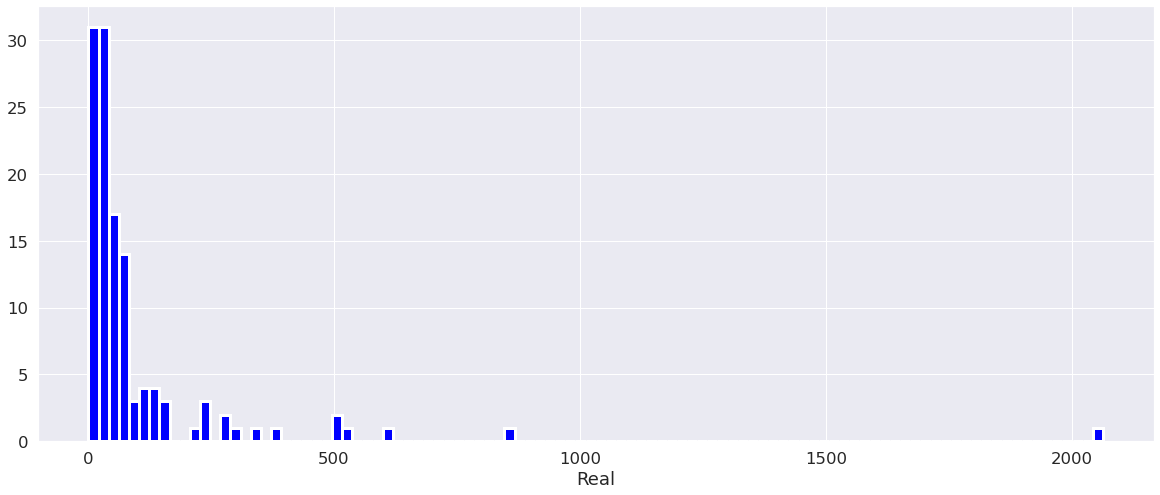

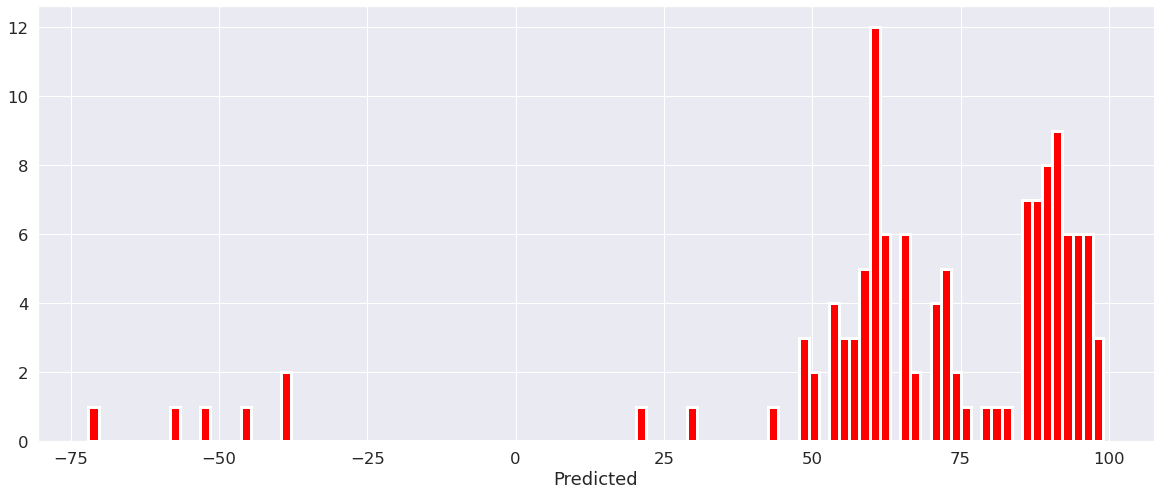


Validating mlp_q on set 6 and 2017-05
932 121
RMSE : 283.3291
MAPE': 2.0250
MDAPE': 0.7823
MSE: 80275.3554
MAE: 119.6033
R2: -0.0767


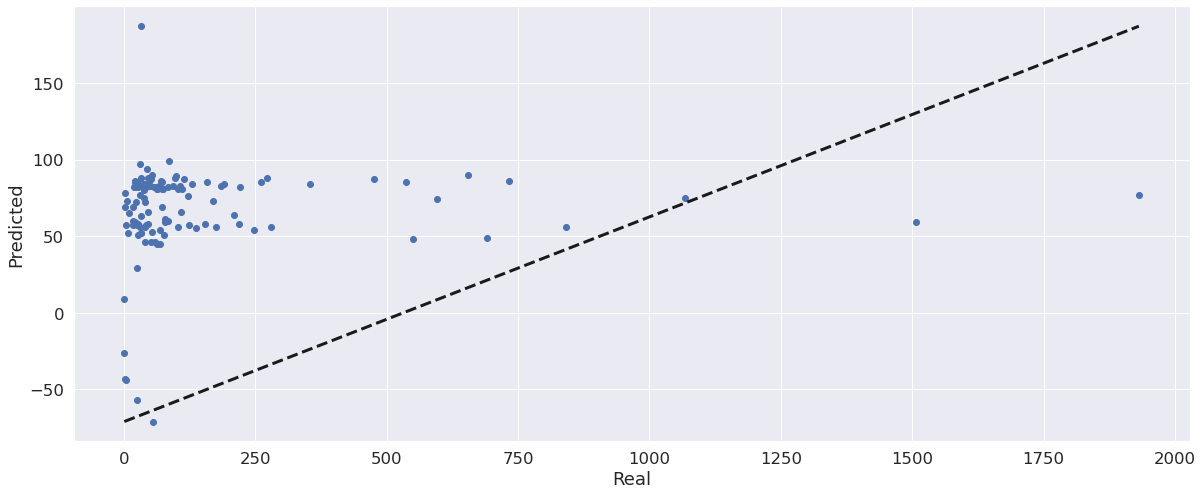

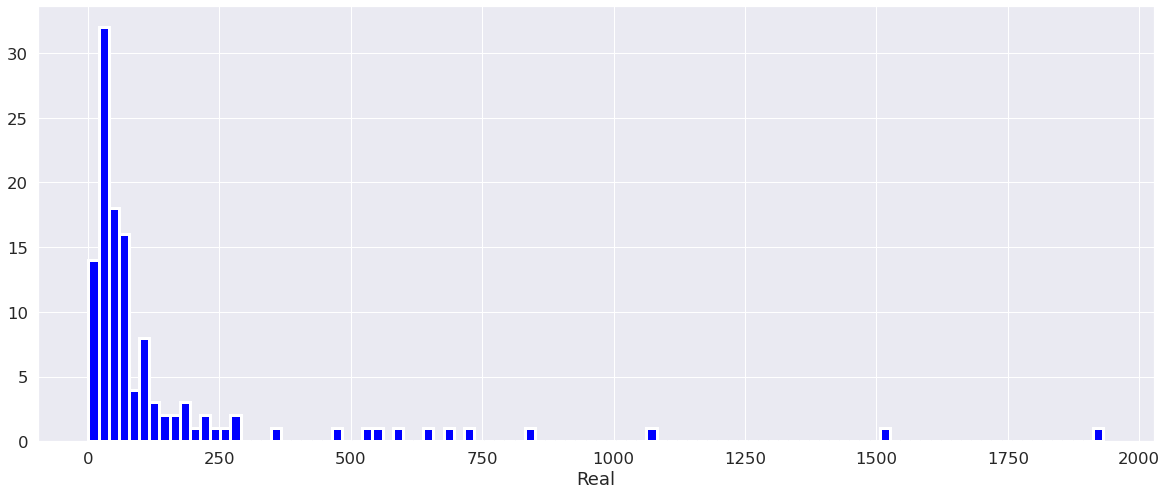

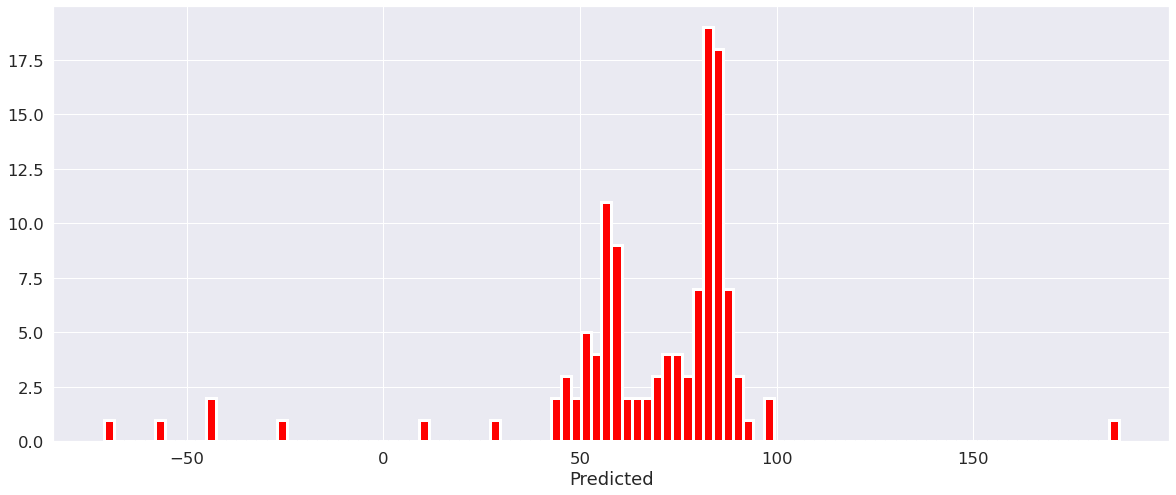

In [22]:
results = []
for r_name, r in regressors.items():
    s=6
    x_scaler = StandardScaler()

    df_set = df_train_val_test[(df_train_val_test.set == s)]

    x_scaler = MinMaxScaler()

    train_years = parse_str_list(df_set.train.values[0])
    val_years = parse_str_list(df_set.val.values[0])
    print(f'Training {r_name} on set {s}')

    df_train = df_dataset_v2[df_dataset_v2.year_month.isin(train_years)]    

    y_train = df_train['Y'].values    
    df_val = df_dataset_v2[df_dataset_v2.year_month.isin(val_years)]
    y_val = df_val['Y'].values
        
    if 'mlp' in r_name:
            r_inst = r.fit(X=x_scaler.fit_transform(df_train[X_cols]), y=y_train, 
                       X_val = x_scaler.transform(df_val[X_cols]), y_val = y_val)
    else: 
            r_inst = r.fit(X=x_scaler.fit_transform(df_train[X_cols]), y=y_train)
        
    for val_year in val_years:
        df_val = df_dataset_v2[df_dataset_v2.year_month == val_year]
        print(f'Validating {r_name} on set {s} and {val_year}')
        y_val = df_val['Y']
        y_pred_val = r_inst.predict(x_scaler.transform(df_val[X_cols]))

        y_pred_val = y_pred_val
        m = _metrics.applyRegressionMetrics(y=y_val, y_pred=y_pred_val)
        m['reg_inst'] = r_inst
        m['r_name'] = r_name
        m['set'] = s
        m['year_month'] = val_year
        results.append(m)
        print(len(y_train), len(y_val))
        _metrics.evaluateRegression(y=y_val, y_pred=y_pred_val)
        print()
df_results = pd.DataFrame(results)    

In [23]:
df_results[[c for c in df_results.columns if  c not in ['y', 'y_pred']]].sort_values('year_month')

,RMSE,MAPE,MDAPE,MSE,MAE,R2,reg_inst,r_name,set,year_month
0,147.402714,3.078747,0.783784,21727.560000,70.728000,0.613454,LGBMRegressor(random_state=42),gbm,6,2017-03
3,203.281145,1.707429,0.555556,41323.224000,76.456000,0.264837,"LGBMRegressor(alpha=0.5, metric='quantile', ob...",gbm_q,6,2017-03
6,199.523071,2.036941,0.571429,39809.456000,74.992000,0.291767,([DecisionTreeRegressor(criterion='friedman_ms...,gb_q,6,2017-03
9,240.090366,6.057933,0.920328,57643.384000,105.128000,-0.025508,<src.mlp_quantile.QuantileModel object at 0x7f...,mlp_q,6,2017-03
1,134.309619,2.803022,0.716272,18039.073770,67.073770,0.631173,LGBMRegressor(random_state=42),gbm,6,2017-04
4,187.755138,1.077531,0.506250,35251.991803,66.991803,0.279238,"LGBMRegressor(alpha=0.5, metric='quantile', ob...",gbm_q,6,2017-04
7,199.327435,1.072941,0.541742,39731.426230,64.983607,0.187651,([DecisionTreeRegressor(criterion='friedman_ms...,gb_q,6,2017-04
10,222.666699,3.903722,0.896672,49580.459016,90.327869,-0.013722,<src.mlp_quantile.QuantileModel object at 0x7f...,mlp_q,6,2017-04
2,184.604446,8.383375,0.755319,34078.801653,96.123967,0.542915,LGBMRegressor(random_state=42),gbm,6,2017-05
5,236.865167,0.879612,0.666667,56105.107438,100.842975,0.247485,"LGBMRegressor(alpha=0.5, metric='quantile', ob...",gbm_q,6,2017-05
